## Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import os
import torchvision
import torchvision.transforms.functional as TF
import random
import glob
from torchmetrics import JaccardIndex
from torchmetrics.classification import Dice
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
import sys
sys.path.append('../src/')
import preprocess
#import json2mask
import constant
from model import Unet
from segformer_dataset import SemanticSegmentationDataset

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from datasets import load_metric
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import random
from collections import OrderedDict

## PARAMETERS

In [4]:
VALID_SIZE = 0.2
TEST_SIZE  = 0.1
BATCH_SIZE = 4
EPOCHS = 5
CUDA = True
INPUT_SHAPE = (224, 224)
N_CLASSES = 2

## Data Preparation

In [5]:
ROOT_DIR='C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\'

In [6]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [7]:
image_paths=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out')
mask_paths=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks')
line_mask_paths=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\line_masks')
mask_on_image_path=os.listdir('C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masked_images')

In [8]:
for i in range(len(image_paths)):
    image_paths[i]=ROOT_DIR+"img_out\\"+image_paths[i]

In [9]:
for i in range(len(mask_paths)):
    mask_paths[i]=ROOT_DIR+"masks\\"+mask_paths[i]

In [10]:
for i in range(len(line_mask_paths)):
    line_mask_paths[i]=ROOT_DIR+"line_masks\\"+line_mask_paths[i]

In [11]:
for i in range(len(mask_on_image_path)):
    mask_on_image_path[i]=ROOT_DIR+"masked_images\\"+mask_on_image_path[i]

## Train_Test Splitting

In [12]:
X_train,X_test,y_train,y_test=train_test_split(image_paths,mask_paths,train_size=0.8,random_state=42,shuffle=True)

In [13]:
print(f"Train data size {len(X_train)}")
print(f"Test data size {len(X_test)}")

Train data size 3728
Test data size 932


In [14]:
id2label={
    0:"Background",
    1:"Freespace"
}

In [15]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.size = 224
feature_extractor.do_reduce_labels=False
train_dataset=SemanticSegmentationDataset(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,train=True,id2label=id2label,feature_extractor=feature_extractor)
valid_dataset=SemanticSegmentationDataset(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,train=False,id2label=id2label,feature_extractor=feature_extractor)

C:\Users\Beytullah\anaconda3\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\Beytullah\anaconda3\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [16]:
encoded_input=train_dataset[0]

In [17]:
encoded_input["pixel_values"]

tensor([[[ 0.2967,  0.2796,  0.2796,  ..., -0.0801, -0.0972, -0.0629],
         [ 0.2796,  0.2796,  0.3138,  ..., -0.0972, -0.1314, -0.0801],
         [ 0.3138,  0.3138,  0.2967,  ..., -0.1314, -0.0629, -0.0629],
         ...,
         [-1.0733, -1.0904, -1.0562,  ..., -0.6623, -0.6623, -0.6452],
         [-1.0733, -1.1247, -1.0733,  ..., -0.6452, -0.6794, -0.6794],
         [-0.9705, -1.0390, -1.1075,  ..., -0.6623, -0.6623, -0.6452]],

        [[ 0.7479,  0.7304,  0.7304,  ...,  0.5553,  0.5553,  0.5553],
         [ 0.7479,  0.7304,  0.7304,  ...,  0.5553,  0.5728,  0.5728],
         [ 0.7304,  0.7304,  0.7304,  ...,  0.5728,  0.5728,  0.5728],
         ...,
         [-0.8627, -0.8803, -0.8452,  ..., -0.4601, -0.4426, -0.4426],
         [-0.8803, -0.9153, -0.8627,  ..., -0.4776, -0.4601, -0.4601],
         [-0.8102, -0.8452, -0.8978,  ..., -0.4601, -0.4776, -0.4426]],

        [[ 1.5071,  1.5071,  1.3677,  ...,  1.6465,  1.6291,  1.7337],
         [ 1.4722,  1.4722,  1.4374,  ...,  1

In [18]:
encoded_input['labels']

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

In [19]:
print(f'Shape of encoded input training_data {encoded_input["pixel_values"].shape}')
print(f'Shape of encoded input labels {encoded_input["labels"].shape}')

Shape of encoded input training_data torch.Size([3, 224, 224])
Shape of encoded input labels torch.Size([224, 224])


In [20]:
mask=encoded_input["labels"].numpy()

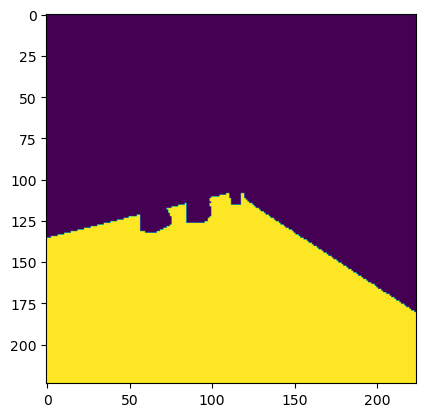

In [21]:
plt.imshow(mask)

In [22]:
label2id = {v:k for k,v in id2label.items()}

In [23]:
label2id

{'Background': 0, 'Freespace': 1}

In [24]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,num_workers=0)

In [25]:
batch = next(iter(train_dataloader))

In [26]:
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4, 224, 224])


In [27]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_n

In [31]:
from transformers import AdamW

In [32]:
optimizer = AdamW(model.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

Model Initialized!


C:\Users\Beytullah\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

In [32]:
for epoch in range(1, 6):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        mask = (labels != 255) # we don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                mask = (labels != 255) # we don't include the background class in the accuracy calculation
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs.loss
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())

    print(f"Train Pixel-wise accuracy: {sum(accuracies)/len(accuracies)}\
         Train Loss: {sum(losses)/len(losses)}\
         Val Pixel-wise accuracy: {sum(val_accuracies)/len(val_accuracies)}\
         Val Loss: {sum(val_losses)/len(val_losses)}")

Epoch: 1


  0%|          | 0/932 [00:00<?, ?it/s]

## Save Model

In [33]:
torch.save(model,"segformer.pth")

In [34]:
BACKGROUND=(0,0,0)
FREESPACE=(255,255,255)

In [35]:
RGB={
    
    0:BACKGROUND,
    1:FREESPACE
    
    
}

In [36]:
feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)

pixel_values = feature_extractor_inference(plt.imread(X_test[0]), return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [37]:
model.eval()
outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 2, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

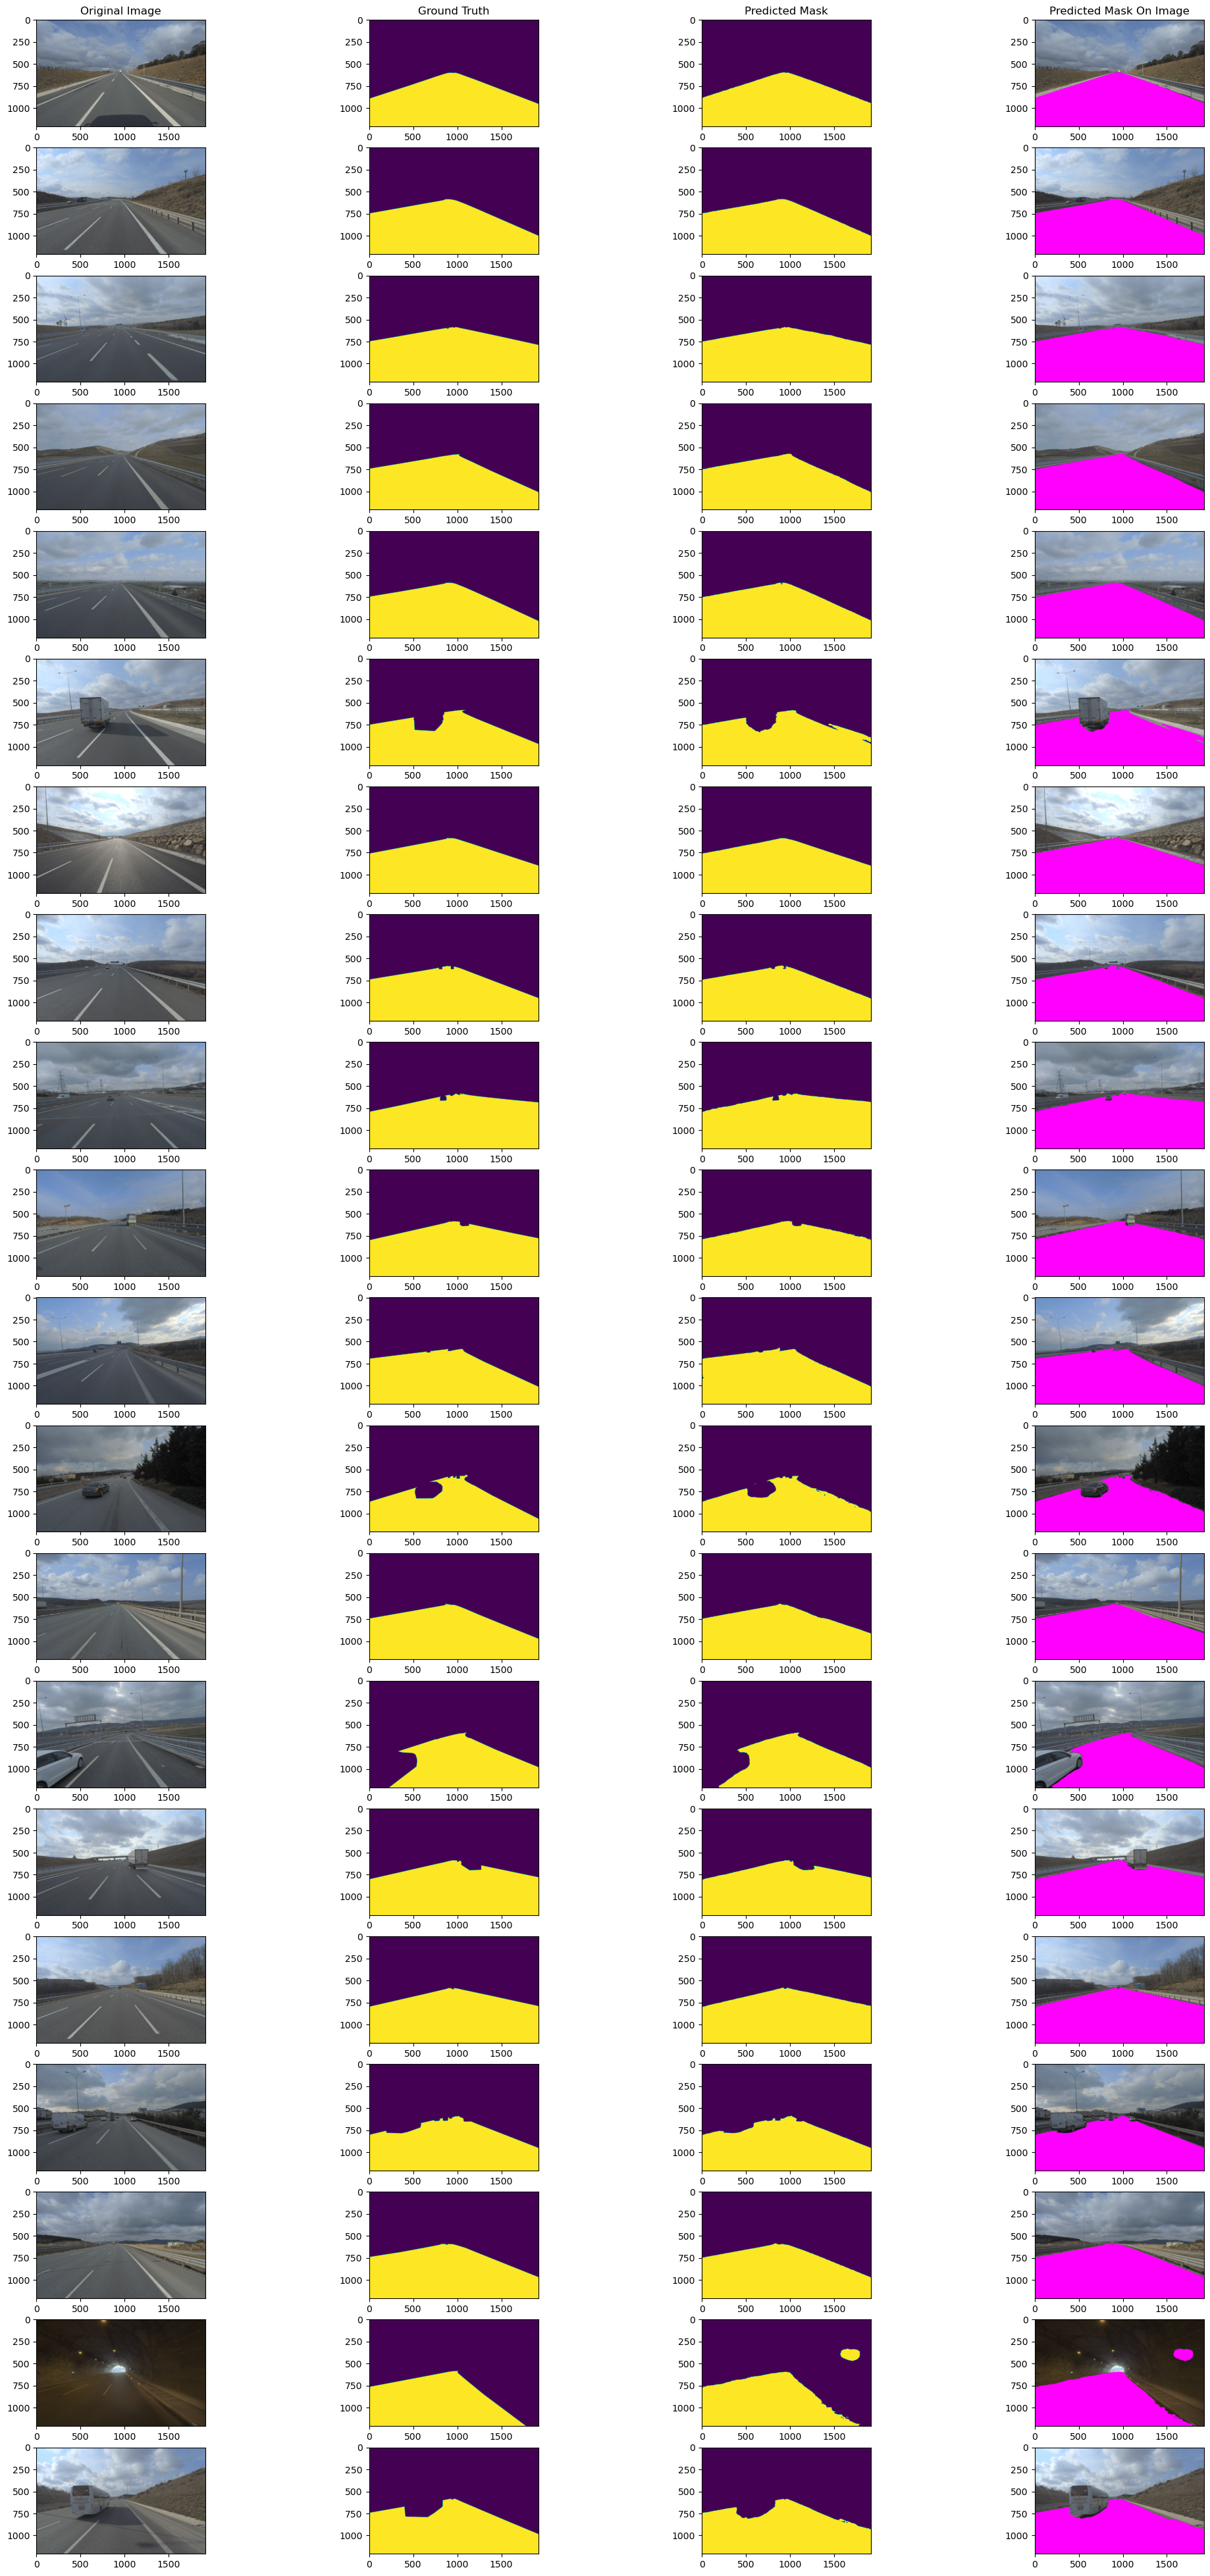

In [38]:
fig,axs=plt.subplots(nrows=20,ncols=4,figsize=(25,50))
for i in range(0,20):
    rand_idx=random.randint(0,len(X_test)-1)
    feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)
    image=plt.imread(X_test[rand_idx])
    mask=plt.imread(y_test[rand_idx])
    pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
    model.eval()
    outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
    logits = outputs.logits.cpu()
    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(logits,
                size=image.shape[:-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
    seg = upsampled_logits.argmax(dim=1)[0]
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3\
    for label, color in enumerate(RGB):
        color_seg[seg == label, :] = RGB[label]
# Convert to BGR
    color_seg = color_seg[..., ::-1]

# Show image + mask
    img = np.array(image)

    if i ==0:
        axs[i][0].set_title('Original Image')
        axs[i][1].set_title('Ground Truth')
        axs[i][2].set_title("Predicted Mask")
        axs[i][3].set_title('Predicted Mask On Image')
    axs[i][0].imshow(img)
    axs[i][1].imshow(mask)
    axs[i][2].imshow(color_seg[:,:,1])
    overlay_img = img.copy()
    mask_alpha = 0.4
    img[color_seg[:,:,1]==255,:]=(255,0,255)

    axs[i][3].imshow(img)
    

## Inference on random test_image with trained segformer model

In [70]:
model=torch.load("C:\\Users\\Beytullah\\Desktop\\models\\segformer.pth")

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [121]:
def predict(input_image_path:str):
    feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)
    image=plt.imread(input_image_path)
    pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
    model.eval()
    outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
    logits = outputs.logits.cpu()
    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(logits,
                size=image.shape[:-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
    seg = upsampled_logits.argmax(dim=1)[0]
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3\
    for label, color in enumerate(RGB):
        color_seg[seg == label, :] = RGB[label]
# Convert to BGR
    color_seg = color_seg[..., ::-1]

# Show image + mask
    img = np.array(image)
    img[color_seg[:,:,1]==255,:]=(255,0,255)
    return img,color_seg[:,:,1]
    
    

## Calculate mean IOU score from 100 test images

In [93]:
def calculate_iou(ground_truth_mask,predicted_mask):
    
    intersection = np.logical_and(ground_truth_mask, predicted_mask)

    union = np.logical_or(ground_truth_mask, predicted_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score
    
    

In [95]:
import tqdm

In [96]:
iou_scores=[]
for i in tqdm.tqdm(range(0, 100)):
    rand_idx=random.randint(0,len(X_test)-1)
    feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)
    image=plt.imread(X_test[i])
    mask=plt.imread(y_test[i])
    pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
    model.eval()
    outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
    logits = outputs.logits.cpu()
    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(logits,
                size=image.shape[:-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
    seg = upsampled_logits.argmax(dim=1)[0]
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3\
    for label, color in enumerate(RGB):
        color_seg[seg == label, :] = RGB[label]
# Convert to BGR
    color_seg = color_seg[..., ::-1]

# Show image + mask
    img = np.array(image)
    overlay_img = img.copy()
    mask_alpha = 0.4
    img[color_seg[:,:,1]==255,:]=(255,0,255)
    iou_score=calculate_iou(mask,color_seg[:,:,1])
    iou_scores.append(iou_score)
    



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:31<00:00,  2.72s/it]


C:\Users\Beytullah\anaconda3\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 IOU Score 0.9964269361940665


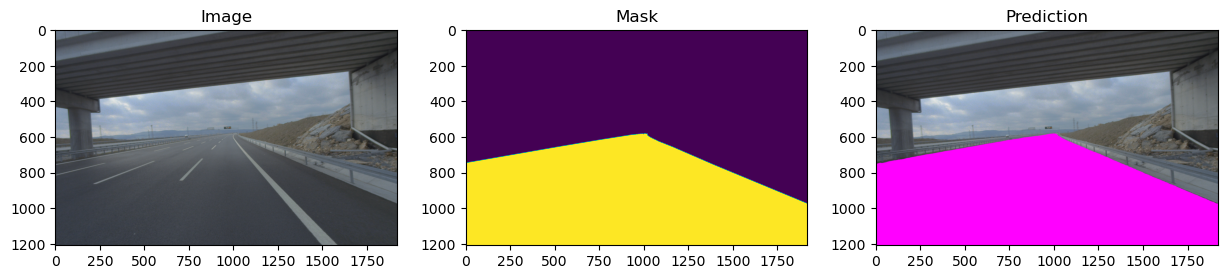

In [146]:
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(15,15))
image=plt.imread("C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_002397_2d46cef20fc7464184eefe3c79d48a02.png")
mask=plt.imread("C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\masks\\cfc_002397_2d46cef20fc7464184eefe3c79d48a02.png")
prediction,color_seg=predict("C:\\Users\\Beytullah\\Desktop\\Ford Otosan Staj Verileri\\img_out\\cfc_002397_2d46cef20fc7464184eefe3c79d48a02.png")
axs[0].set_title("Image")
axs[0].imshow(image)
axs[1].set_title("Mask")
axs[1].imshow(mask)
axs[2].set_title("Prediction")
axs[2].imshow(prediction)
print(f" IOU Score {calculate_iou(mask,color_seg)}")

In [142]:
mean_iou_score=sum(iou_scores)/100

In [145]:
print(mean_iou_score)

0.9894445434355832
